In [ ]:
import os.path as op
from google.colab import drive


drive.mount('/content/drive')


if op.isfile('/content/drive/My Drive/chks/epoch_no.log'):
  with open('/content/drive/My Drive/chks/epoch_no.log') as file:
    epo = file.readline()
else:
  epo = 1

print('Last checkpoint at: ',epo,'. Resuming from here.')
last_epoch = int(epo)
experiment = 9


Mounted at /content/drive
Last checkpoint at:  2200 . Resuming from here.


# Experiments

01 Originalexperiement 2020 DCGAN: no dropout, generator with all leakyRelu activation

02 2020 DCGAN wie swish-activation for generator and dicriminator: did not work well

03 2020 DCGAN with swish activation for generator

04 2020 DCGAN with swish activation for generator and dropout 0.3 for generator and dicriminator

05 2020 DCGAN experiment 05 with dropout of 0.5 for both disc and gen

06 2021 DCGAN experiment 06 with dropout of 0.5 for gen & crit, not for cirtic, swish in generator; counter shows 1300 epoch too much: nach 1500 Epochen abgebrochen, da keinerlei Bewegung in Generatorloss. Es scheint, dass immer wieder verloren geht, was gerade gewonnen wurde -> Dropout 0.5 scheint deutlich yu hoch.

07 2021 DCGAN experiment 05 with dropout of 0.3 like experiment 04, but longer; canceled at epoch 2250 because of divergence instead of convergence

08 2021 DCGAN experiment 07 ab 2250 without dropout

09 Generator no dropout, Discriminator 0.3 dropout, NOISE_SIZE = 1024




##### Copyright 2019 The TensorFlow Authors.

### Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
#tf.test.gpu_device_name()
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
#import psutil
#import humanize
#import os
#import GPUtil as GPU
#GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
#gpu = GPUs[0]
#def printm():
# process = psutil.Process(os.getpid())
# print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
# print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))#
#printm() 

In [ ]:
# To generate GIFs
!pip install imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

from datetime import datetime

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
#print(len(train_images))
#print(len(train_images[0]))
#print(len(train_images[0][0]))
#print(train_images[0].shape)
#plt.imshow(train_images[0])

In [ ]:
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
#print(len(train_images))
#print(len(train_images[0]))
#print(len(train_images[0][0]))
#print(train_images[0].shape)
#plt.imshow(train_images[0])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

folder = '/content/drive/My Drive/CTScans/CT_COVID'


onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

imgs = []
for of in onlyfiles:
  print('working on: ', of)
  img = load_img(folder + "/" + of, target_size=(336,504))
  #print(img.size)
  img1= img.convert('L')
  img1 = np.expand_dims(img1, axis = -1)
  imgs.append(img1)
  


imgs = np.asarray(imgs).astype('float32')


In [ ]:
train_images = (imgs - 127.5)/127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 20
NOISE_SIZE  = 200

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### The Generator



In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(84*126*256, use_bias=False, input_shape=(NOISE_SIZE,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Activation(activations.swish))


    model.add(layers.Reshape((84,126, 256)))
    assert model.output_shape == (None, 84,126, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 84,126, 128)
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.Activation(activations.swish))
    #model.add(layers.Dropout(0.3))


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 168,252, 64)
    model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU())
    model.add(layers.Activation(activations.swish))
    #model.add(layers.Dropout(0.3))
    #added 2 dropout layers 12/2021

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 336,504 ,1)

    return model

Use the (as yet untrained) generator to create an image.

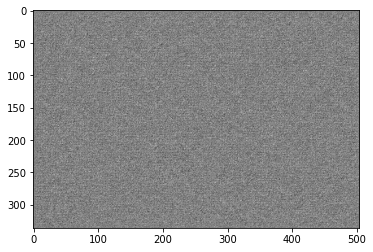

In [ ]:
from keras import activations
generator = make_generator_model()

noise = tf.random.normal([1, NOISE_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[336,504, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    #model.add(layers.Activation(activations.swish))

    model.add(layers.Dropout(0.3))
    #uncommented the dropout layers 12/2021
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[9.9587254e-05]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(5e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
img_dir = '/content/drive/My Drive/chkimgs'
checkpoint_dir = '/content/drive/My Drive/chks'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [ ]:
EPOCHS = 10000
noise_dim = 200
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return [gen_loss,disc_loss]

In [ ]:
def make_loss_graph(in_losses):
  y_gen_los = [i[0] for i in in_losses]
  y_crt_los = [i[1] for i in in_losses]
  x_line = range(0,len(in_losses))
  plt.plot(x_line, y_gen_los, label = 'Gen')
  plt.plot(x_line, y_crt_los, label = 'Dcr')
  plt.legend()
  plt.show()

In [ ]:
def train(dataset, epochs, last_epoch):
  losses_chain = []
  for epoch in range(last_epoch,epochs):
    start = time.time()

    for image_batch in dataset:
      losses = train_step(image_batch)
      #tf.print('losses: ',losses)
      #print('b ', losses[0], losses[0].numpy())
      #losses_chain.append([losses[0].numpy(), losses[1].numpy()]) 
      # don t need append here -> causes too many values
      #print(losses_chain)

    # Produce images for the GIF as we go
    if epoch%20 == 0:   #done by me
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch,
                             seed)
      make_loss_graph(losses_chain)

    # Save the model every 15 epochs
    if (epoch)%400 == 0: #changed 15 to 150
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('checkpoint saved: ', epoch)
      with open('/content/drive/My Drive/chks/epoch_no.log', 'w') as file:
        file.write(str(epoch))

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    losses_chain.append([losses[0].numpy(), losses[1].numpy()])

    print ('Time for epoch {0:10d} is {1:.3f} sec (loss gen {2:.3f}, crit {3:.3f}) time: {4}'.format(epoch, time.time()-start, losses[0].numpy(), losses[1].numpy() , current_time ))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('{0}/image_at_epoch_{1:05d}.png'.format(img_dir, epoch+last_epoch))
  plt.show()

In [ ]:

if last_epoch != 1:
  print('Loading latest_checkpoint with epoch no: ', last_epoch)
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  print('Done loading latest_checkpoint')
else:
  print('There is no latest_checkpoint for this experiment.')


Loading latest_checkpoint with epoch no:  2200
Done loading latest_checkpoint


## Train the model


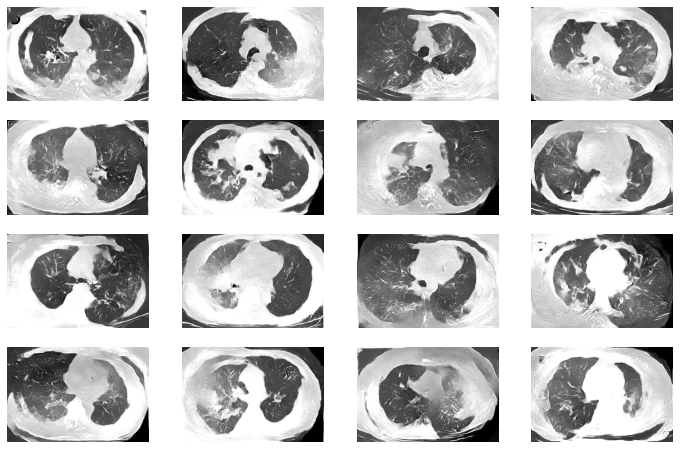

Training time was 46500.77116513252 sec   -  10:57:49


In [ ]:
xtime = time.time()
print(xtime)
train(train_dataset, EPOCHS, last_epoch)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print ('Training time was {} sec'.format(time.time()-xtime),'  - ', current_time)
